In [5]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Flatten
from tensorflow.keras.layers import Dense, Reshape, Input, BatchNormalization
from tensorflow.data import Dataset

from plt_fn import show_images

IMAGE_SHAPE = (128,128)
tf.random.set_seed(10)

In [6]:
def crop_white_space(img):
    def allWhiteRow(row):
        return all(el[0] > 120 for el in row)
    def allWhiteColumn(index, img): 
        return all(el[index][0] >120 for el in img)
    
    start_column = 0
    while(allWhiteColumn(start_column, img)): start_column += 1

    end_column = img.shape[0] - 1
    while(allWhiteColumn(end_column, img)): end_column -= 1
    
    start_row = 0
    while(allWhiteRow(img[start_row])): start_row += 1
        
    end_row = img.shape[1] - 1
    while(allWhiteRow(img[end_row])): end_row -= 1
        
#     print(start_column, end_column, start_row, end_row)
    
    pad = 5
    
    img = tf.image.crop_to_bounding_box(
        img, 
        start_row - pad if start_row - pad > 0 else 0, 
        start_column - pad if start_column - pad > 0 else 0, 
        end_row - start_row + 2* pad if end_row + pad < 128 else end_row - start_row, 
        end_column - start_column +2* pad if end_column + pad < 128 else end_column - start_column)
    img = tf.image.resize(img, (128, 128))
    return img

In [16]:
def preprocessing_fun(img):
#     print(img.shape, img.astype(int))
#     print(filename)
#     img = cv2.imread(filename)
#     gray = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR).astype(np.uint8)
    gray = img.astype(np.uint8)
#     img = cv2.fastNlMeansDenoising(gray,None,5,7,21)
#     img = cv2.fastNlMeansDenoising(gray, None, 3, 7, 21)
    ret,thresh = cv2.threshold(img,170,255,cv2.THRESH_BINARY)
    kernel = np.ones((5, 5), np.uint8)
    erode = cv2.erode(thresh, kernel, iterations = 1)
    img = cv2.bitwise_or(img, erode)
    
    kernel = np.ones((1, 1), np.uint8)
    img = cv2.erode(thresh, kernel, iterations = 1)
    
    dec = 60
    img = np.where(img < 250, img - dec, img)
    
    gray = 255*(img < 128).astype(np.uint8)
    coords = cv2.findNonZero(gray)
    x, y, w, h = cv2.boundingRect(coords)
    rect = img[y:y+h, x:x+w]
    
#     img = cv2.copyMakeBorder(rect,top,bottom,right,left,cv2.BORDER_CONSTANT,value=255)
    img = cv2.copyMakeBorder(rect,5,5,5,5,cv2.BORDER_CONSTANT,value=255)
    img = cv2.resize(img, (80,80), interpolation = cv2.INTER_NEAREST)
#     img = cv2.convertScaleAbs(img, alpha=0.5, beta=0)
#     gray = img.astype(np.uint8)
#     img = cv2.fastNlMeansDenoising(gray,None,5,7,21)
#     img = cv2.blur(img, (5, 5))
    img = img.reshape(80,80,1)
#     img = crop_white_space(img)
    
    return img

In [17]:
img_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    preprocessing_function = preprocessing_fun,
    validation_split=0.25
)

In [18]:
training_gen = img_datagen.flow_from_directory(
    'TRAIN',
    target_size=(80,80),
    color_mode='grayscale',
    batch_size=128,
    shuffle=True,
    seed=10,
    subset="training"
)
validation_gen = img_datagen.flow_from_directory(
    'TRAIN',
    target_size=(80,80),
    color_mode='grayscale',
    batch_size=128,
    shuffle=True,
    seed=10,
    subset="validation"
)

Found 12028 images belonging to 33 classes.
Found 3997 images belonging to 33 classes.


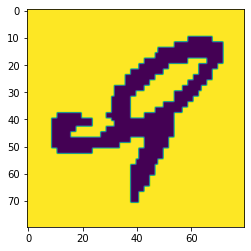

In [19]:
# print(training_gen[1][0][0])
plt.imshow(training_gen[1][0][0].astype("uint8"))


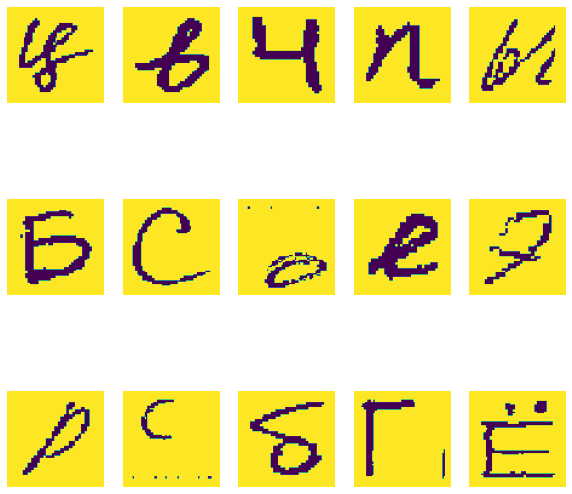

In [20]:
plt.figure(figsize=(10, 10))
def show_images(train_ds, class_names, n = 9):
    images, labels = train_ds[2]
    for i in range(15):
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(images[i].astype("uint8"))
#         plt.title(class_names[labels[i]])
        plt.axis("off")
show_images(training_gen, np.array(set(training_gen.labels)))

In [21]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    'TRAIN',
    shuffle=True,
    image_size=IMAGE_SHAPE,
    color_mode='grayscale',
    validation_split=0.75,
    subset="training",
    batch_size=128,
    seed=1337
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    'TRAIN',
    shuffle=True,
    image_size=IMAGE_SHAPE,
    color_mode='grayscale',
    validation_split=0.25,
    subset="validation",
    batch_size=128,
    seed=1337
)


Found 16025 files belonging to 33 classes.
Using 4007 files for training.


2022-01-31 16:34:38.721988: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-01-31 16:34:38.722019: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mj-i511k-nikolaevskaya): /proc/driver/nvidia/version does not exist
2022-01-31 16:34:38.724832: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 16025 files belonging to 33 classes.
Using 4006 files for validation.


In [3]:
class_names = train_ds.class_names
print(class_names)

['а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', 'ё']


In [27]:
train_ds_center = train_ds.as_numpy_iterator()
new_images = []
new_y = []
for batch,y in train_ds_center:
    new_img = [crop_white_space(img) for img in batch]
    new_images.append(new_img)
    new_y.append(y)

In [28]:
train_ds_center = Dataset.from_tensor_slices((new_images[:29], new_y[:29]))  
train_ds_center

<TensorSliceDataset element_spec=(TensorSpec(shape=(128, 80, 80, 1), dtype=tf.float32, name=None), TensorSpec(shape=(128,), dtype=tf.int32, name=None))>

In [29]:
val_ds_center = val_ds.as_numpy_iterator()
val_new_images = []
val_new_y = []
for batch,y in val_ds_center:
    new_img = [crop_white_space(img) for img in batch]
    val_new_images.append(new_img)
    val_new_y.append(y)

In [30]:
val_ds_center = Dataset.from_tensor_slices((val_new_images[:29], val_new_y[:29]))  
val_ds_center

<TensorSliceDataset element_spec=(TensorSpec(shape=(128, 80, 80, 1), dtype=tf.float32, name=None), TensorSpec(shape=(128,), dtype=tf.int32, name=None))>

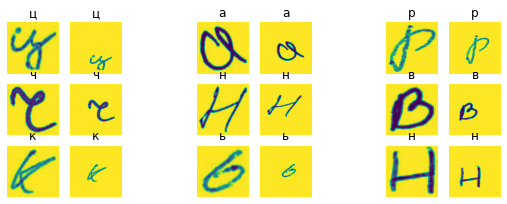

In [26]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(9, 9, 3*i + 1)
        im = crop_white_space(images[i])
        plt.imshow(im.numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
        ax = plt.subplot(9, 9, 3*i + 2)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
        
#         m = tf.math.greater(images[i], tf.constant([64.0]))
# #         erosion = -tf.nn.max_pool3d(~m, ksize=(5, 5, 1), padding='SAME',strides=1, name='erosion3D')
#         imm = np.bitwise_or(images[i].numpy().astype("uint8"), m)
# #         print(imm)
#         imm = crop_white_space(imm)
#         ax = plt.subplot(9, 9, 3*i + 3)
#         plt.imshow(imm)
#         plt.title(class_names[labels[i]])
#         plt.axis("off")
#         erosion = -tf.nn.max_pool2d(-x, ksize=(5, 5), stride=1, name='erosion2D')
#         kernel = np.ones((5, 5), np.uint8)
#         erode = cv2.erode(thresh, kernel, iterations = 1)
#         result = cv2.bitwise_or(img, erode)

In [22]:
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(80,80, 1))
]

In [37]:
def conv_2d_pooling_layers(filters):
    return [
        tf.keras.layers.Conv2D(
            filters,
            (2,2),
            activation='relu',
            padding='same'
        ),
        tf.keras.layers.MaxPooling2D()
    ]
core_layers = \
    conv_2d_pooling_layers(32) + \
    conv_2d_pooling_layers(64) + \
    conv_2d_pooling_layers(128)

In [38]:
dense_layers = [
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(33)
]

In [39]:
model = tf.keras.Sequential(
    preprocessing_layers +
    core_layers +
    dense_layers
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 80, 80, 1)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 80, 80, 32)        160       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 40, 40, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 40, 40, 64)        8256      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 20, 20, 128)      

In [40]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer='adam',
    loss=loss,
    metrics=['accuracy']
)

In [41]:
history = model.fit(
    training_gen,
    validation_data = validation_gen,
    epochs = 20
)

Epoch 1/20
94/94 [==============================] - 21s 220ms/step - loss: 3.4941 - accuracy: 0.0354 - val_loss: 3.4907 - val_accuracy: 0.0383
Epoch 2/20
94/94 [==============================] - 21s 223ms/step - loss: 3.4905 - accuracy: 0.0373 - val_loss: 3.4891 - val_accuracy: 0.0390
Epoch 3/20
94/94 [==============================] - 21s 223ms/step - loss: 3.4890 - accuracy: 0.0380 - val_loss: 3.4886 - val_accuracy: 0.0390
Epoch 4/20
94/94 [==============================] - 23s 247ms/step - loss: 3.4889 - accuracy: 0.0388 - val_loss: 3.4881 - val_accuracy: 0.0383
Epoch 5/20
94/94 [==============================] - 22s 238ms/step - loss: 3.4885 - accuracy: 0.0380 - val_loss: 3.4878 - val_accuracy: 0.0390
Epoch 6/20
26/94 [=======>......................] - ETA: 13s - loss: 3.4877 - accuracy: 0.0373

KeyboardInterrupt: 

In [29]:
model.evaluate(validation_gen)

32/32 [==============================] - 2s 60ms/step - loss: 0.8320 - accuracy: 0.7931


[0.8320024013519287, 0.7930948138237]

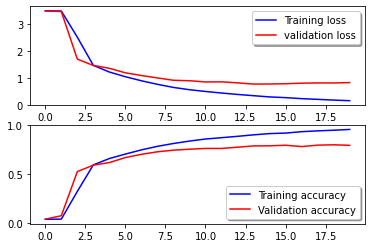

In [30]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [33]:
predict = model.predict(validation_gen)

In [43]:
np.argmax(predict[0])

1

In [31]:
model.save('weight/20-epoch')

2022-01-31 16:43:02.035070: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: weight/20-epoch/assets
